# Import Libraries

In [2]:
# Shawn Schwartz, 2018
# shawnschwartz@ucla.edu
# The Alfaro Lab at UCLA

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import scipy.spatial.distance as dist
import os
from os import walk, listdir
import warnings
import sys

Using TensorFlow backend.


# Define Functions for Clustering

## Define "getFishDirs" Function

In [3]:
# obtain all subdirs of fish
def getFishDirs(file_path):
    randall_fish = [f.path for f in os.scandir(file_path) if f.is_dir()]
    
    return(randall_fish)

## Define "getFishSubDirs" Function

In [4]:
def getFishSubDirs(subdirs_path, emptyPaths_array):
    for i in range(len(subdirs_path)):
        for (dirpath, dirnames, filenames) in walk(subdirs_path[i]):
            for j in range(len(filenames)):
                img = dirpath + '/' + filenames[j]
                if "Store" not in img:
                    emptyPaths_array.append(img)
            break
            
    return(emptyPaths_array)

## Get Fish "Species" Paths per "Family" Subdirectories

In [5]:
# Input File Path of Images Parent Directory
randall_dirpath = '/Users/shawn/Developer/randall_testing/'

# Call getFishDirs for Parent Directory and Store
fish_subdirs = getFishDirs(randall_dirpath)

# Init empty array for individual subdir fish family paths
fish_paths = []

# Call getFishSubDirs for SubDirs and Store
fish_paths = getFishSubDirs(fish_subdirs, fish_paths)

## Initialize and Define VGG16 Imagenet Model

In [6]:
model = VGG16(weights='imagenet', include_top=False)

vgg16_feature_list = []

warnings.filterwarnings('ignore')

## Define "processTheFish" (VGG16 Image Processing) Function

In [7]:
def processTheFish(desiredPaths_set, vgg16_model):
    # Print Information for Peace of Mind
    print("Beginning Image Processing for...")
    #print(desiredClusters, " Desired Number of Clusters!")
    
    for i, fname in enumerate(desiredPaths_set):
        # process image files within pre-fetched subdirs
        img = image.load_img(desiredPaths_set[i], target_size=(224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        
        vgg16_feature = vgg16_model.predict(img_data)
        vgg16_feature_np = np.array(vgg16_feature)
        vgg16_feature_list.append(vgg16_feature_np.flatten())
        
        # Print image processing progress percentage in console for Peace of Mind
        sys.stdout.write("\r{0}".format((float(i)/len(desiredPaths_set))*100))
        sys.stdout.flush()
        
    print("\nImage Processing Completed!")
    
    vgg16_feature_list_np = np.array(vgg16_feature_list)
    
    return(vgg16_feature_list_np)

## Define "clusterTheFish" (KMeans Clustering) Function

In [8]:
def clusterTheFish(desiredClusters, imported_vgg16_feature_list_np):
    kmeans = KMeans(n_clusters=desiredClusters, random_state=0).fit(imported_vgg16_feature_list_np)
    
    print("VGG16 Feature List and KMeans Computed.")
    
    return(kmeans)

## Define "scoreTheFish" (Internal Clusuter Validation Silhouette Scoring) Function

In [9]:
def scoreTheFish(imported_Kmeans, imported_vgg16_feature_list_np):
    predicted_labels = imported_Kmeans.labels_
    
    ICV_Score = metrics.silhouette_score(imported_vgg16_feature_list_np, predicted_labels, metric='euclidean')
    
    # Print out Internal Cluster Validation Score
    print("\nInternal Cluster Validation Score:", ICV_Score)
    
    # Print out Predicted Cluster ID Labels
    print("\nPredicted Clusters:", predicted_labels)
    
    return(predicted_labels, ICV_Score)

## Define "writeListToFile" (non-np array) Function

In [10]:
def writeListToFile(fishy_paths_list, filename):
    # Write the file paths list to its own CSV file
    
    with open(filename, "w") as outfile:
        for entries in fishy_paths_list:
            outfile.write(entries)
            outfile.write("\n")

## Define "saveOutputCSV" Function

In [11]:
def saveOutputCSV(desClustNums, cluster_output_filename, fish_paths_output_filename, concat_clusters_fishpaths_filename, pred_labels_output, fish_file_paths):
    cluster_output_filename = str(desClustNums) + "_DesiredClusters-" + cluster_output_filename
    fish_paths_output_filename = str(desClustNums) + '_DesiredClusters-' + fish_paths_output_filename
    concat_clusters_fishpaths_filename = str(desClustNums) + '_DesiredClusters-' + concat_clusters_fishpaths_filename
    
    # save separate CSV files
    np.savetxt(cluster_output_filename, pred_labels_output, delimiter=",")
    writeListToFile(fish_file_paths, fish_paths_output_filename)
    
    # concatenate paths and cluster identification CSVs
    colOne = pd.read_csv(cluster_output_filename)
    colTwo = pd.read_csv(fish_paths_output_filename)
    colCat = pd.concat([colTwo, colOne], axis=1)
    colCat.to_csv(concat_clusters_fishpaths_filename, index=False)
    
    # remove temp pre-merged single-rowed CSVs from Dir
    os.remove(cluster_output_filename)
    os.remove(fish_paths_output_filename)

# Run Image Processing Clustering

In [12]:
vgg16_fish_featureList_np = processTheFish(fish_paths, model)

Beginning Image Processing for...
99.173553719008276
Image Processing Completed!


## Testing For 2-20 Desired Clusters

## Initialize Output Filename Consts

In [23]:
clusterOutputFname = "predictedClsts_randall.csv"
fishPathsOutputFname = "fishPaths_randall.csv"
concatClustsFishpathsFname = "overallPredictions_outputData.csv"

### Run For 2 Desired Clusters

In [24]:
numClusts = 2
twoClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
twoClusters_ICVScore = scoreTheFish(twoClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(twoClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.06905871

Predicted Clusters: [0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 1 1 1 0 0 1 0 0 0]

Internal Cluster Validation Score: 0.06905871

Predicted Clusters: [0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 1 1 1 0 0 1 0 0 0]


### Run For 3 Desired Clusters

In [25]:
numClusts = 3
threeClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
threeClusters_ICVScore = scoreTheFish(threeClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(threeClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.05857872

Predicted Clusters: [0 1 1 2 2 2 0 2 1 1 1 2 2 0 2 2 0 1 2 1 0 1 0 1 2 0 1 0 0 2 2 2 0 0 1 2 2
 2 2 2 0 1 1 2 2 2 0 1 2 2 1 2 2 1 2 2 2 2 2 1 1 2 0 0 0 0 2 0 1 0 2 1 1 0
 0 1 2 0 2 2 0 2 1 2 1 2 2 0 1 2 1 0 0 2 1 2 0 2 0 2 2 2 1 1 2 2 0 2 2 2 0
 0 0 1 1 2 1 0 2 1 2]

Internal Cluster Validation Score: 0.05857872

Predicted Clusters: [0 1 1 2 2 2 0 2 1 1 1 2 2 0 2 2 0 1 2 1 0 1 0 1 2 0 1 0 0 2 2 2 0 0 1 2 2
 2 2 2 0 1 1 2 2 2 0 1 2 2 1 2 2 1 2 2 2 2 2 1 1 2 0 0 0 0 2 0 1 0 2 1 1 0
 0 1 2 0 2 2 0 2 1 2 1 2 2 0 1 2 1 0 0 2 1 2 0 2 0 2 2 2 1 1 2 2 0 2 2 2 0
 0 0 1 1 2 1 0 2 1 2]


### Run For 4 Desired Clusters

In [26]:
numClusts = 4
fourClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
fourClusters_ICVScore = scoreTheFish(fourClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(fourClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.064996146

Predicted Clusters: [0 2 1 1 1 1 2 1 1 2 2 1 1 2 2 1 0 2 1 3 0 2 1 3 1 2 3 0 0 1 1 1 0 2 3 1 1
 1 1 1 2 2 1 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 1 2 3 1 0 0 0 0 1 0 2 0 1 2 3 0
 0 2 1 2 1 2 0 1 3 2 2 1 1 2 2 1 1 2 2 1 1 1 2 1 0 1 1 1 3 1 1 1 0 1 1 1 2
 1 0 2 2 1 1 0 1 2 1]

Internal Cluster Validation Score: 0.064996146

Predicted Clusters: [0 2 1 1 1 1 2 1 1 2 2 1 1 2 2 1 0 2 1 3 0 2 1 3 1 2 3 0 0 1 1 1 0 2 3 1 1
 1 1 1 2 2 1 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 1 2 3 1 0 0 0 0 1 0 2 0 1 2 3 0
 0 2 1 2 1 2 0 1 3 2 2 1 1 2 2 1 1 2 2 1 1 1 2 1 0 1 1 1 3 1 1 1 0 1 1 1 2
 1 0 2 2 1 1 0 1 2 1]


### Run For 5 Desired Clusters

In [27]:
numClusts = 5
fiveClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
fiveClusters_ICVScore = scoreTheFish(fiveClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(fiveClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.04247954

Predicted Clusters: [3 0 3 2 1 1 0 1 3 0 0 1 2 0 1 2 3 0 2 1 4 0 3 0 2 2 0 3 4 2 1 1 3 0 0 1 1
 1 2 1 3 0 3 2 2 2 3 3 1 1 3 1 2 3 1 1 1 1 2 0 0 2 4 4 4 4 1 2 3 3 2 2 0 3
 2 0 1 0 2 0 4 1 1 1 0 2 1 0 3 1 3 0 0 1 2 3 2 2 4 2 2 1 0 3 2 2 4 1 2 2 0
 3 4 2 0 2 3 4 1 3 1]

Internal Cluster Validation Score: 0.04247954

Predicted Clusters: [3 0 3 2 1 1 0 1 3 0 0 1 2 0 1 2 3 0 2 1 4 0 3 0 2 2 0 3 4 2 1 1 3 0 0 1 1
 1 2 1 3 0 3 2 2 2 3 3 1 1 3 1 2 3 1 1 1 1 2 0 0 2 4 4 4 4 1 2 3 3 2 2 0 3
 2 0 1 0 2 0 4 1 1 1 0 2 1 0 3 1 3 0 0 1 2 3 2 2 4 2 2 1 0 3 2 2 4 1 2 2 0
 3 4 2 0 2 3 4 1 3 1]


### Run For 6 Desired Clusters

In [28]:
numClusts = 6
sixClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
sixClusters_ICVScore = scoreTheFish(sixClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(sixClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.043311466

Predicted Clusters: [3 2 2 1 5 5 3 5 2 2 2 5 1 4 5 1 3 2 1 0 3 2 4 2 1 1 0 3 3 1 5 5 3 4 4 5 5
 5 1 5 3 2 2 1 1 1 3 2 5 5 2 5 1 2 5 5 4 5 1 2 0 1 3 3 3 3 5 3 3 3 1 3 0 3
 3 2 5 4 1 5 3 5 0 4 2 1 5 3 2 5 2 3 3 5 3 3 1 1 3 1 1 5 0 2 1 1 3 5 1 1 4
 3 3 1 2 1 2 3 5 2 5]

Internal Cluster Validation Score: 0.043311466

Predicted Clusters: [3 2 2 1 5 5 3 5 2 2 2 5 1 4 5 1 3 2 1 0 3 2 4 2 1 1 0 3 3 1 5 5 3 4 4 5 5
 5 1 5 3 2 2 1 1 1 3 2 5 5 2 5 1 2 5 5 4 5 1 2 0 1 3 3 3 3 5 3 3 3 1 3 0 3
 3 2 5 4 1 5 3 5 0 4 2 1 5 3 2 5 2 3 3 5 3 3 1 1 3 1 1 5 0 2 1 1 3 5 1 1 4
 3 3 1 2 1 2 3 5 2 5]


### Run For 7 Desired Clusters

In [29]:
numClusts = 7
sevenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
sevenClusters_ICVScore = scoreTheFish(sevenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(sevenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.032255642

Predicted Clusters: [3 6 4 2 1 1 6 4 4 6 6 4 4 6 1 2 3 6 2 4 3 6 3 5 4 6 5 3 3 2 1 1 3 3 5 1 1
 1 2 4 3 6 4 2 4 4 3 4 4 1 6 4 2 4 1 4 4 1 2 6 5 2 3 3 3 3 0 3 3 3 2 3 5 3
 3 6 0 3 2 1 3 1 4 1 6 2 4 6 6 1 4 3 3 1 4 4 6 4 3 2 2 1 5 4 2 2 3 1 2 2 3
 3 3 6 6 2 4 3 1 6 4]

Internal Cluster Validation Score: 0.032255642

Predicted Clusters: [3 6 4 2 1 1 6 4 4 6 6 4 4 6 1 2 3 6 2 4 3 6 3 5 4 6 5 3 3 2 1 1 3 3 5 1 1
 1 2 4 3 6 4 2 4 4 3 4 4 1 6 4 2 4 1 4 4 1 2 6 5 2 3 3 3 3 0 3 3 3 2 3 5 3
 3 6 0 3 2 1 3 1 4 1 6 2 4 6 6 1 4 3 3 1 4 4 6 4 3 2 2 1 5 4 2 2 3 1 2 2 3
 3 3 6 6 2 4 3 1 6 4]


### Run For 8 Desired Clusters

In [30]:
numClusts = 8
eightClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
eightClusters_ICVScore = scoreTheFish(eightClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(eightClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.048017465

Predicted Clusters: [3 0 2 1 1 1 5 1 2 5 0 1 1 5 5 3 4 0 1 6 4 0 6 7 1 3 7 3 4 1 1 1 3 5 5 6 1
 6 1 1 1 5 2 1 1 1 4 2 1 1 3 1 1 2 1 1 6 1 1 0 7 1 4 4 4 4 1 3 3 3 1 3 7 4
 3 3 1 5 3 5 5 1 6 5 5 1 1 3 2 1 2 5 5 1 1 1 3 1 3 3 1 1 7 2 1 3 4 1 3 1 5
 3 4 3 5 3 2 4 1 2 1]

Internal Cluster Validation Score: 0.048017465

Predicted Clusters: [3 0 2 1 1 1 5 1 2 5 0 1 1 5 5 3 4 0 1 6 4 0 6 7 1 3 7 3 4 1 1 1 3 5 5 6 1
 6 1 1 1 5 2 1 1 1 4 2 1 1 3 1 1 2 1 1 6 1 1 0 7 1 4 4 4 4 1 3 3 3 1 3 7 4
 3 3 1 5 3 5 5 1 6 5 5 1 1 3 2 1 2 5 5 1 1 1 3 1 3 3 1 1 7 2 1 3 4 1 3 1 5
 3 4 3 5 3 2 4 1 2 1]


### Run For 9 Desired Clusters

In [31]:
numClusts = 9
nineClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
nineClusters_ICVScore = scoreTheFish(nineClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(nineClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.04004892

Predicted Clusters: [2 1 3 3 5 5 8 3 3 8 1 3 3 8 8 3 2 1 5 7 2 1 2 7 3 8 7 2 4 3 3 5 2 8 7 5 5
 5 3 5 2 8 3 3 3 3 2 3 3 5 0 3 3 3 5 3 5 5 3 1 7 3 4 2 2 2 3 2 3 4 3 2 7 2
 2 0 3 8 6 8 4 5 7 5 7 3 5 4 0 5 3 4 4 3 3 3 8 3 4 3 3 3 7 3 3 3 2 5 3 3 8
 2 4 6 8 3 3 4 5 0 3]

Internal Cluster Validation Score: 0.04004892

Predicted Clusters: [2 1 3 3 5 5 8 3 3 8 1 3 3 8 8 3 2 1 5 7 2 1 2 7 3 8 7 2 4 3 3 5 2 8 7 5 5
 5 3 5 2 8 3 3 3 3 2 3 3 5 0 3 3 3 5 3 5 5 3 1 7 3 4 2 2 2 3 2 3 4 3 2 7 2
 2 0 3 8 6 8 4 5 7 5 7 3 5 4 0 5 3 4 4 3 3 3 8 3 4 3 3 3 7 3 3 3 2 5 3 3 8
 2 4 6 8 3 3 4 5 0 3]


### Run For 10 Desired Clusters

In [32]:
numClusts = 10
tenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
tenClusters_ICVScore = scoreTheFish(tenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(tenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.027109418

Predicted Clusters: [4 9 1 0 3 3 9 3 1 1 9 3 6 9 9 6 4 9 6 3 4 9 3 5 6 9 5 4 2 6 3 3 4 8 5 3 3
 3 6 3 4 5 1 6 6 6 4 1 3 6 1 3 6 1 3 6 3 3 6 9 5 0 8 4 4 4 3 6 4 4 6 4 5 4
 6 9 3 8 7 9 8 3 3 9 9 6 3 9 1 3 1 8 8 3 4 4 9 6 2 6 6 3 5 1 6 6 4 3 6 6 8
 4 2 7 5 6 1 8 3 1 3]

Internal Cluster Validation Score: 0.027109418

Predicted Clusters: [4 9 1 0 3 3 9 3 1 1 9 3 6 9 9 6 4 9 6 3 4 9 3 5 6 9 5 4 2 6 3 3 4 8 5 3 3
 3 6 3 4 5 1 6 6 6 4 1 3 6 1 3 6 1 3 6 3 3 6 9 5 0 8 4 4 4 3 6 4 4 6 4 5 4
 6 9 3 8 7 9 8 3 3 9 9 6 3 9 1 3 1 8 8 3 4 4 9 6 2 6 6 3 5 1 6 6 4 3 6 6 8
 4 2 7 5 6 1 8 3 1 3]


### Run For 11 Desired Clusters

In [33]:
numClusts = 11
elevenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
elevenClusters_ICVScore = scoreTheFish(elevenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(elevenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.02781823

Predicted Clusters: [ 3  8  9  4 10  2  7  6  9  9  8  2  6  5  2  4  3  8  6  1  3  8  3  1
  6  1  1  3  0  4  4  2  3  7  1  2  2  2  4  2  3  1  9  4  6  6  3  9
  6 10  9  2  6  9  2  2 10 10  4  8  1  4  0  3  3  3  6  3  3  7  4  3
  1  3  3  8  2  0  6  5  0  2  1 10  1  4  2  7  9  2  9  7  0  6  3  4
  4  6  7  4  4  4  1  9  4  4  3 10  4  4  1 10  0  1  1  6  9  0 10  9
  2]

Internal Cluster Validation Score: 0.02781823

Predicted Clusters: [ 3  8  9  4 10  2  7  6  9  9  8  2  6  5  2  4  3  8  6  1  3  8  3  1
  6  1  1  3  0  4  4  2  3  7  1  2  2  2  4  2  3  1  9  4  6  6  3  9
  6 10  9  2  6  9  2  2 10 10  4  8  1  4  0  3  3  3  6  3  3  7  4  3
  1  3  3  8  2  0  6  5  0  2  1 10  1  4  2  7  9  2  9  7  0  6  3  4
  4  6  7  4  4  4  1  9  4  4  3 10  4  4  1 10  0  1  1  6  9  0 10  9
  2]


### Run For 12 Desired Clusters

In [34]:
numClusts = 12
twelveClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
twelveClusters_ICVScore = scoreTheFish(twelveClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(twelveClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.03295989

Predicted Clusters: [ 0  4  2  2  3  3 11  3  6 11  4  1  1 11  3  1  0  4  3  9  0  4  6  7
  1 11  7  0 10  2  8  8  0  5  7  8  3  8  2  3  0  6  2  2  1  1  0  6
  3  3  6  3  1  6  3  8  3  3  2  4  7  2  0  0  0  0  1  0  6 10  2  0
  7  0  0  6  8  5  6 11 11  3  9  3  6  3  3 10  6  3  6 11 11  3  1  2
 11  1 11  1  2  3  7  6  2  2  0  3  1  2  5  0  0  6 11  1  6  0  3  6
  8]

Internal Cluster Validation Score: 0.03295989

Predicted Clusters: [ 0  4  2  2  3  3 11  3  6 11  4  1  1 11  3  1  0  4  3  9  0  4  6  7
  1 11  7  0 10  2  8  8  0  5  7  8  3  8  2  3  0  6  2  2  1  1  0  6
  3  3  6  3  1  6  3  8  3  3  2  4  7  2  0  0  0  0  1  0  6 10  2  0
  7  0  0  6  8  5  6 11 11  3  9  3  6  3  3 10  6  3  6 11 11  3  1  2
 11  1 11  1  2  3  7  6  2  2  0  3  1  2  5  0  0  6 11  1  6  0  3  6
  8]


### Run For 13 Desired Clusters

In [35]:
numClusts = 13
thirteenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
thirteenClusters_ICVScore = scoreTheFish(thirteenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(thirteenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.040069267

Predicted Clusters: [ 6  4  8  1  5  2  6  3  3  3  4  3  1  6  6  1 10  4  2 11 10  4  5  7
  2  6  7  0  4  1  5  5  6  9  7  5  5  5  1  3  0  3  8  2  1  2 10  3
  3  2  3  3  1  8  5  1  5  5  2  4  7  1  9 10 10 10  3  0  8  8  1  0
  7  8  0  4  3  9 12  6 10  5 11  6  3  1  5  4  3  5  3  9  9  2  3  3
  6  1  6  1  1  5  7  3  1  1 10  2  1  1  9  6 10 12  6  1  8  9  2  3
  3]

Internal Cluster Validation Score: 0.040069267

Predicted Clusters: [ 6  4  8  1  5  2  6  3  3  3  4  3  1  6  6  1 10  4  2 11 10  4  5  7
  2  6  7  0  4  1  5  5  6  9  7  5  5  5  1  3  0  3  8  2  1  2 10  3
  3  2  3  3  1  8  5  1  5  5  2  4  7  1  9 10 10 10  3  0  8  8  1  0
  7  8  0  4  3  9 12  6 10  5 11  6  3  1  5  4  3  5  3  9  9  2  3  3
  6  1  6  1  1  5  7  3  1  1 10  2  1  1  9  6 10 12  6  1  8  9  2  3
  3]


### Run For 14 Desired Clusters

In [36]:
numClusts = 14
fourteenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
fourteenClusters_ICVScore = scoreTheFish(fourteenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(fourteenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.03581279

Predicted Clusters: [ 1 11 12  6  7  4  7 12 12 12 11 12  6  7  7  6  1 11  4 10  1 11  1  9
  6  7  9  5 13  6  4  3  5 13  9  3  4  3  4  4  5  9 12  0  6  6  1 12
  6  7  8 12  6 12  4  4  3  2  6 11  9  4 13  1  1  1  6  5  5  5  4  5
  9  5  5 11 12 13  6  7 13  4 10  7 12  6  3  5  8  4 12 13 13  6 12  1
  7  6 13  6  6  4  9 12  6  0  1  2  6  6 13  7 13  7  7  6 12 13  2  8
  4]

Internal Cluster Validation Score: 0.03581279

Predicted Clusters: [ 1 11 12  6  7  4  7 12 12 12 11 12  6  7  7  6  1 11  4 10  1 11  1  9
  6  7  9  5 13  6  4  3  5 13  9  3  4  3  4  4  5  9 12  0  6  6  1 12
  6  7  8 12  6 12  4  4  3  2  6 11  9  4 13  1  1  1  6  5  5  5  4  5
  9  5  5 11 12 13  6  7 13  4 10  7 12  6  3  5  8  4 12 13 13  6 12  1
  7  6 13  6  6  4  9 12  6  0  1  2  6  6 13  7 13  7  7  6 12 13  2  8
  4]


### Run For 15 Desired Clusters

In [37]:
numClusts = 15
fifteenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
fifteenClusters_ICVScore = scoreTheFish(fifteenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(fifteenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.042459633

Predicted Clusters: [11  3  4  0  9  9 12  0 11  4  3  9  0 12  2  0 13  3  9  6 13  3 11  5
  9 12  5  8  8  0  9  9 14  1  2  7  9  7  0  9  4  2  4  0  0  0 14  4
  0  0 11  9  0  4  9  9 11  9  0  3  5  0  1 13 13 13  0 12 11  8  0 12
  5 14  0 11  4  1 10 12  1  9  6 12 12  0  4  8 11  9  4  1  1  9  0  0
 12  0  8  0  0  9  5  4  0  0 13  9  0  0  2 12  8 10  2  0  4  1  9 11
  9]

Internal Cluster Validation Score: 0.042459633

Predicted Clusters: [11  3  4  0  9  9 12  0 11  4  3  9  0 12  2  0 13  3  9  6 13  3 11  5
  9 12  5  8  8  0  9  9 14  1  2  7  9  7  0  9  4  2  4  0  0  0 14  4
  0  0 11  9  0  4  9  9 11  9  0  3  5  0  1 13 13 13  0 12 11  8  0 12
  5 14  0 11  4  1 10 12  1  9  6 12 12  0  4  8 11  9  4  1  1  9  0  0
 12  0  8  0  0  9  5  4  0  0 13  9  0  0  2 12  8 10  2  0  4  1  9 11
  9]


### Run For 16 Desired Clusters

In [38]:
numClusts = 16
sixteenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
sixteenClusters_ICVScore = scoreTheFish(sixteenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(sixteenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.03342973

Predicted Clusters: [ 8 10  0  1 14 12  6  9  0  6 10 14  9  6  6  1  8 10 12  3  8 10 14  7
  1  1  3  1 15  1  2  2  1  6  6  2  2  2  0  9 11  6  0 12  1  1  8  0
  9  2  5  9  1  0  9  2 14  2 12 10  7  1  8  8  8  8  9  1 11  1  1  1
  7  0  1  5  9  6 13  6 15  2  3 12  6  1 14 15  5 12  0 15  4  1  1  1
  6  1 15  1  1  9  7  0 12  1  8  2  1  1  6  1 15 13  6  1  0  4 12  5
  2]

Internal Cluster Validation Score: 0.03342973

Predicted Clusters: [ 8 10  0  1 14 12  6  9  0  6 10 14  9  6  6  1  8 10 12  3  8 10 14  7
  1  1  3  1 15  1  2  2  1  6  6  2  2  2  0  9 11  6  0 12  1  1  8  0
  9  2  5  9  1  0  9  2 14  2 12 10  7  1  8  8  8  8  9  1 11  1  1  1
  7  0  1  5  9  6 13  6 15  2  3 12  6  1 14 15  5 12  0 15  4  1  1  1
  6  1 15  1  1  9  7  0 12  1  8  2  1  1  6  1 15 13  6  1  0  4 12  5
  2]


### Run For 17 Desired Clusters

In [39]:
numClusts = 17
seventeenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
seventeenClusters_ICVScore = scoreTheFish(seventeenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(seventeenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.038434975

Predicted Clusters: [ 9 14  7  3 13 13  2 15  7  4 14  7  0  4 13  3  9 14 13 16  9 14  8  1
 15  2  1  9 10  3  6 13  9 11  1  7 13  7  3 15 13  4  7  3  0  3  9  7
 15 13 14 15 15  7 13  7  8 13 15 14  1  3 10  9  9  5 15  9  4 10  3  9
  1  9  9 14  7  4 12  2 10  6 16 13  4  3 13  2 14 13  7  2  2 13  0  9
  2  3 10  3  3  6  1  7  3  3  5 13  3  3 11 13 10 12  4  3  7 10 13 14
  7]

Internal Cluster Validation Score: 0.038434975

Predicted Clusters: [ 9 14  7  3 13 13  2 15  7  4 14  7  0  4 13  3  9 14 13 16  9 14  8  1
 15  2  1  9 10  3  6 13  9 11  1  7 13  7  3 15 13  4  7  3  0  3  9  7
 15 13 14 15 15  7 13  7  8 13 15 14  1  3 10  9  9  5 15  9  4 10  3  9
  1  9  9 14  7  4 12  2 10  6 16 13  4  3 13  2 14 13  7  2  2 13  0  9
  2  3 10  3  3  6  1  7  3  3  5 13  3  3 11 13 10 12  4  3  7 10 13 14
  7]


### Run For 18 Desired Clusters

In [40]:
numClusts = 18
eighteenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
eighteenClusters_ICVScore = scoreTheFish(eighteenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(eighteenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.04099325

Predicted Clusters: [ 9 17  7  3 13 13  2 15  7  4 17  7  0  4 13  3  9 17 13 16  9 17  8  1
 15  2  1  9 10  3  6 13  9 11  1  7 13  7  3 15 13  4  7  3  0  3  9  7
 15 13 14 15 15  7 13  7  8 13 15 17  1  3 10  9  9  5 15  9  4 10  3  9
  1  9  9 14  7  4 12  2 10  6 16 13  4  3 13  2 14 13  7  2  2 13  0  9
  2  3 10  3  3  6  1  7  3  3  5 13  3  3 11 13 10 12  4  3  7 10 13 14
  7]

Internal Cluster Validation Score: 0.04099325

Predicted Clusters: [ 9 17  7  3 13 13  2 15  7  4 17  7  0  4 13  3  9 17 13 16  9 17  8  1
 15  2  1  9 10  3  6 13  9 11  1  7 13  7  3 15 13  4  7  3  0  3  9  7
 15 13 14 15 15  7 13  7  8 13 15 17  1  3 10  9  9  5 15  9  4 10  3  9
  1  9  9 14  7  4 12  2 10  6 16 13  4  3 13  2 14 13  7  2  2 13  0  9
  2  3 10  3  3  6  1  7  3  3  5 13  3  3 11 13 10 12  4  3  7 10 13 14
  7]


### Run For 19 Desired Clusters

In [41]:
numClusts = 19
nineteenClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
nineteenClusters_ICVScore = scoreTheFish(nineteenClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(nineteenClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.04226616

Predicted Clusters: [ 9 17  7  3 13 13  2 15  7  4 17  7  0  4 13  3  9 17 13 16  9 17  8  1
 15  2  1  9 10  3  6 13  9 11  1  7 13  7  3 15 13  4  7  3  0  3  9  7
 15 13 14 15 15  7 13  7  8 13 15 17  1  3 18 18  9  5 15  9  4 10  3  9
  1  9  9 14  7 18 12  2 18  6 16 13  4  3 13  2 14 13  7  2  2 13  0  9
  2  3 10  3  3  6  1  7  3  3  5 13  3  3 11 13 10 12  4  3  7 18 13 14
  7]

Internal Cluster Validation Score: 0.04226616

Predicted Clusters: [ 9 17  7  3 13 13  2 15  7  4 17  7  0  4 13  3  9 17 13 16  9 17  8  1
 15  2  1  9 10  3  6 13  9 11  1  7 13  7  3 15 13  4  7  3  0  3  9  7
 15 13 14 15 15  7 13  7  8 13 15 17  1  3 18 18  9  5 15  9  4 10  3  9
  1  9  9 14  7 18 12  2 18  6 16 13  4  3 13  2 14 13  7  2  2 13  0  9
  2  3 10  3  3  6  1  7  3  3  5 13  3  3 11 13 10 12  4  3  7 18 13 14
  7]


### Run For 20 Desired Clusters

In [42]:
numClusts = 20
twentyClusters_Kmeans = clusterTheFish(numClusts, vgg16_fish_featureList_np)
twentyClusters_ICVScore = scoreTheFish(twentyClusters_Kmeans, vgg16_fish_featureList_np)[1]

# save output
saveOutputCSV(numClusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreTheFish(twentyClusters_Kmeans, vgg16_fish_featureList_np)[0], fish_paths)

VGG16 Feature List and KMeans Computed.

Internal Cluster Validation Score: 0.044775706

Predicted Clusters: [ 9 17 19  3 13 13  2 15  7  4 17  7  0  4 13  3  9 17 13 16  9 17  8  1
 15  2  1  9 10  3  6 13  9 11  1  7 13  7  3 15 13  4 19  3  0  3  9  7
 15 13 14 15 15  7 13  7  8 13 15 17  1  3 18 18  9  5 15  9  4 10  3  9
  1  9  9 14  7 18 12  2 18  6 16 13  4  3 13  2 14 13  7  2  2 13  0  9
  2  3 10  3  3  6  1  7  3  3  5 13  3  3 11 13 10 12  4  3 19 18 13 14
  7]

Internal Cluster Validation Score: 0.044775706

Predicted Clusters: [ 9 17 19  3 13 13  2 15  7  4 17  7  0  4 13  3  9 17 13 16  9 17  8  1
 15  2  1  9 10  3  6 13  9 11  1  7 13  7  3 15 13  4 19  3  0  3  9  7
 15 13 14 15 15  7 13  7  8 13 15 17  1  3 18 18  9  5 15  9  4 10  3  9
  1  9  9 14  7 18 12  2 18  6 16 13  4  3 13  2 14 13  7  2  2 13  0  9
  2  3 10  3  3  6  1  7  3  3  5 13  3  3 11 13 10 12  4  3 19 18 13 14
  7]


# Plotting Charts

## Matplotlib Bar Chart of ICV Scores

<IPython.core.display.Javascript object>


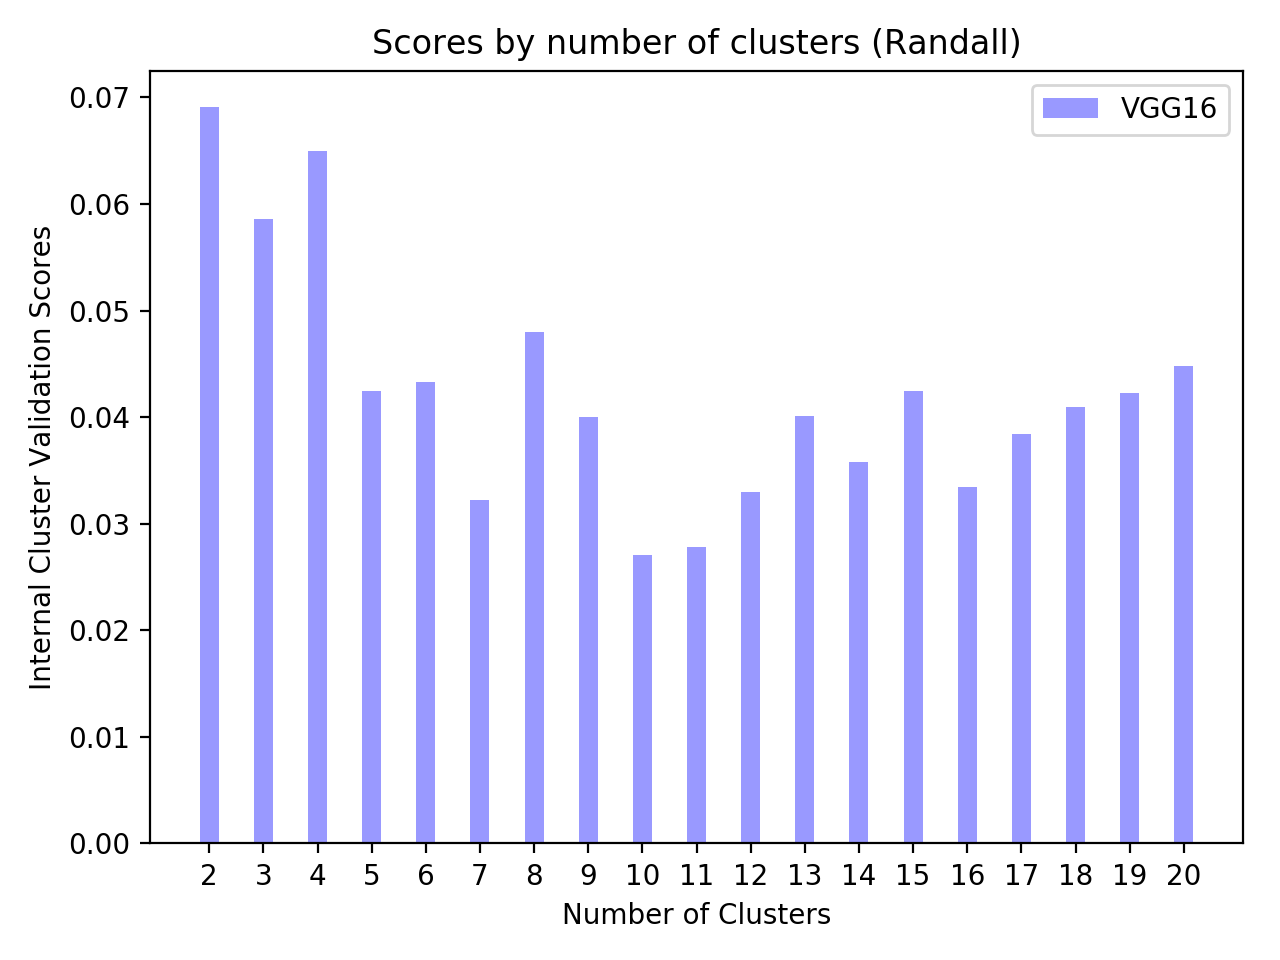

In [43]:
n_groups = 19

clusterICVScores_Means = (twoClusters_ICVScore, threeClusters_ICVScore, fourClusters_ICVScore, fiveClusters_ICVScore, sixClusters_ICVScore, sevenClusters_ICVScore,
                         eightClusters_ICVScore, nineClusters_ICVScore, tenClusters_ICVScore, elevenClusters_ICVScore, twelveClusters_ICVScore,
                         thirteenClusters_ICVScore, fourteenClusters_ICVScore, fifteenClusters_ICVScore, sixteenClusters_ICVScore, seventeenClusters_ICVScore,
                         eighteenClusters_ICVScore, nineteenClusters_ICVScore, twentyClusters_ICVScore)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, clusterICVScores_Means, bar_width,
                alpha=opacity, color='b', 
                error_kw=error_config,
                label='VGG16')


ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Internal Cluster Validation Scores')
ax.set_title('Scores by number of clusters (Randall)')
ax.set_xticks(index)
ax.set_xticklabels(('2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'))
ax.legend()

fig.tight_layout()
plt.show()